# Libraries

In [12]:
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange

# Load Data and Set Parameters

In [36]:
data_name = 'I4D_raw'
brain_data = scipy.io.loadmat('C:\\co\\NIA\\Regularization\\MB_References\\BLSA_1742_04_MCIAD_m41\\' + data_name + '.mat')
I_raw = brain_data[data_name]

slice_roi = 4

#NESMA Filter parameters
txy = 3
tz = 3  
thresh = 5

I_slice = brain_data[data_name][:,:,slice_roi,:]

ms_upper_bound = [1,500,1500]           #GSH - this is the upper bound for where the the multistarts are sampled from
upper_bound_brain = [2,2,500,1500]
ob_weight = 100  
starts = 10
mask_amplitude = 600

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata_brain = np.linspace(t_increment_brain, (I_raw.shape[-1])*(t_increment_brain), I_raw.shape[-1])

estimate_offset = True  #Adds an offset to the signal that is estimate
if estimate_offset:
    upper_bound_brain.append(np.inf)

# NESMA Functions

In [23]:
def NESMA_filtering(raw,txy,tz,thresh,verbose=False):
    #Inputs:
    # raw    : 4D (x,y,z,MS) raw/noisy volume. x,y and z/slice are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # tz     : Defines the size, (2*tz+1) in voxels, of the search window in the z direction (a.k.a slice direction).
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.
    
    # Output:
    # S_NESMA: 4D (x,y,z,MS) NESMA-filtered volume
    
    (m,n,o,p) = raw.shape
    S_NESMA = np.zeros((m,n,o,p))
    
    for k in trange(o):
        if verbose==True:
            print('NESMA filtering ... Slice #', k, 'of', o)
        for i in range(m):
            for j in range(n):
                if raw[i,j,k,0]>10:
                    rmin=max(i-txy,0)
                    rmax=min(i+txy,m)
                    
                    smin=max(j-txy,0)
                    smax=min(j+txy,n)
                    
                    tmin=max(k-tz,0)
                    tmax=min(k+tz,o)
                    
                    L = (rmax-rmin)*(smax-smin)*(tmax-tmin)
                    
                    rawi = np.reshape(raw[rmin:rmax,smin:smax,tmin:tmax,:],(L,p))
                    x=raw[i,j,k,:]
                    
                    D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
                    pos = D<thresh
                    
                    S_NESMA[i,j,k,:] = np.mean(rawi[pos==True, :], axis=0)
                    
    return S_NESMA

def NESMA_filtering_3D(raw,txy,thresh,verbose=False):
    #Inputs:
    # raw    : 3D (x,y,MS) raw/noisy volume. x,y are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.

    # Output:
    # S_NESMA: 3D (x,y,MS) NESMA-filtered volume
    
    (m,n,o) = raw.shape
    S_NESMA = np.zeros((m,n,o))
    
    for j in trange(n):
        if verbose==True and j%50==0:
            print('NESMA filtering ... Slice #', j, 'of', n)
        for i in range(m):
            rmin=max(i-txy,0)
            rmax=min(i+txy,m)
                    
            smin=max(j-txy,0)
            smax=min(j+txy,n)
                    
            L = (rmax-rmin)*(smax-smin)
        
            rawi = np.reshape(raw[rmin:rmax,smin:smax,:],(L,o)) #GSH - Different than the 4D version but seems appropriate
            x=raw[i,j,:]
            
            if x[0] != 0:
                D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x) #This is the Relative Manhattan distance between voxel intensities
                pos = D<thresh
                    
                S_NESMA[i,j,:] = np.mean(rawi[pos==True,:], axis=0)
    
    return S_NESMA

# General Functions

In [37]:
def normalize_brain(I_data):
    n_hori, n_vert, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = I_data[i_hori,i_vert,:]
            if data[0]>0:
                data_normalized = data/(data[0]) #GSH - normalizing by double the maximum/initial signal
            else:
                data_normalized = np.zeros(n_elem)
            I_normalized[i_hori,i_vert,:] = data_normalized
    return I_normalized

def mask_data3(raw, maskAmp = mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<maskAmp] = 0
    return I_masked

def mask_data4(raw, maskAmp = mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,:,0]<maskAmp] = 0
    return I_masked

def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_tilde(lam, SA = 1, offSet = estimate_offset):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    if offSet:
        def Gt_lam(t, con1, con2, tau1, tau2, oS):
            return np.append(G_off(t, con1, con2, tau1, tau2, oS), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    else:
        def Gt_lam(t, con1, con2, tau1, tau2):
            return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def estimate_NLLS_brain(data, lam=0, expt_knowledge = [0,0,0,0], up_bound = upper_bound_brain, post_normalize = True, multistarts = starts, ms_ub = ms_upper_bound, offSet = estimate_offset):
    SA = 1#data[0]
    data_tilde = np.append(data, lam*np.array(expt_knowledge))
    
    (rc1e, rc2e, rT21e, rT22e) = (0, 0, 0, 0)
    RSS_hold = np.inf
    for start in range(multistarts):
        if offSet:
            three_params = np.random.uniform(0,1,3)*ms_ub
            init_params = (three_params[0], 1-three_params[0], three_params[1], three_params[2], 1)
            popt, pcov = curve_fit(
                G_tilde(lam, SA = SA), tdata_brain, data_tilde, bounds = ([0,0,0,0,0], up_bound), p0=init_params, max_nfev = 4000)
            est_curve = G_off(tdata_brain,*popt)
            RSS_temp = np.sum((est_curve - data)**2)
            RSS_pTemp = lam*np.array([1,1,1/ob_weight,1/ob_weight])*popt[0:-1]
            RSS_temp = RSS_temp + np.linalg.norm(RSS_pTemp)
            if RSS_temp < RSS_hold:
                (rc1e, rc2e, rT21e, rT22e) = popt[0:-1]
                RSS_hold = RSS_temp
        else:
            three_params = np.random.uniform(0,1,3)*ms_ub
            init_params = (three_params[0], 1-three_params[0], three_params[1], three_params[2])
            popt, pcov = curve_fit(
                G_tilde(lam, SA = SA), tdata_brain, data_tilde, bounds = ([0,0,0,0], up_bound), p0=init_params, max_nfev = 4000)
            est_curve = G(tdata_brain,*popt)
            RSS_temp = np.sum((est_curve - data)**2)
            RSS_pTemp = lam*np.array([1,1,1/ob_weight,1/ob_weight])*popt
            RSS_temp = RSS_temp + np.linalg.norm(RSS_pTemp)
            if RSS_temp < RSS_hold:
                (rc1e, rc2e, rT21e, rT22e) = popt
                RSS_hold = RSS_temp
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
    #Assume c1 + c2 = 1
    if post_normalize:
        ci_sum = c1est + c2est
        c1est = c1est/ci_sum
        c2est = c2est/ci_sum
        
    return c1est, c2est, T21est, T22est

def create_NLLS_map(raw):
    #Given raw data, create unregularized NLLS maps of c1, c2, T21, and T22
    n_hori, n_vert, _ = raw.shape
    parameter_maps_NLLS = np.zeros((n_hori, n_vert, 4))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = raw[i_hori,i_vert,:]
            if data[0]>0:
                #Adjust the decay curve so that the amplitude is roughly 1
                #data = data/data[0]
                est = np.array(estimate_NLLS_brain(data))
                #After applying NLLS, normalize so that c1 + c2 = 1
                parameter_maps_NLLS[i_hori,i_vert,:] = est
            else:
                parameter_maps_NLLS[i_hori,i_vert,:] = np.zeros(4)
    return parameter_maps_NLLS

# Process Data

In [38]:
I_mask3 = mask_data3(I_slice)
I_mask4 = mask_data4(I_raw)

I_filtered = NESMA_filtering_3D(I_mask3, txy, thresh, verbose = False)

I_filtered_4D = NESMA_filtering(I_mask4, txy, tz, thresh, verbose = False)

print(f"Pixels with differences after 3D filtering = {np.sum(np.sum(np.abs(I_filtered-I_mask3),axis = 2)>0)} out of {I_slice.shape[0]*I_slice.shape[1]}")

print(f"Pixels with differences after 4D filtering = {np.sum(np.sum(np.abs((I_filtered_4D-I_mask4))[:,:,slice_roi,:],axis = 2)>0)} out of {I_slice.shape[0]*I_slice.shape[1]}")

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Pixels with differences after 3D filtering = 583 out of 82944
Pixels with differences after 4D filtering = 686 out of 82944


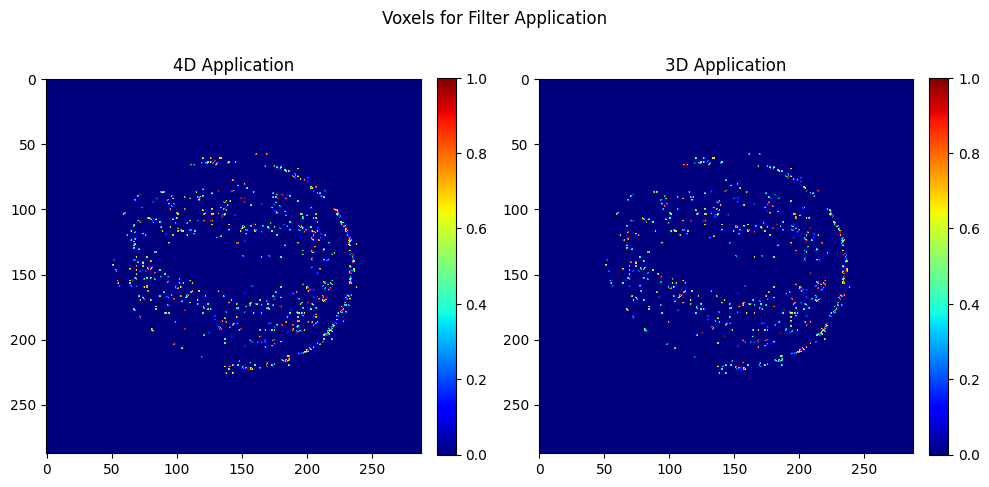

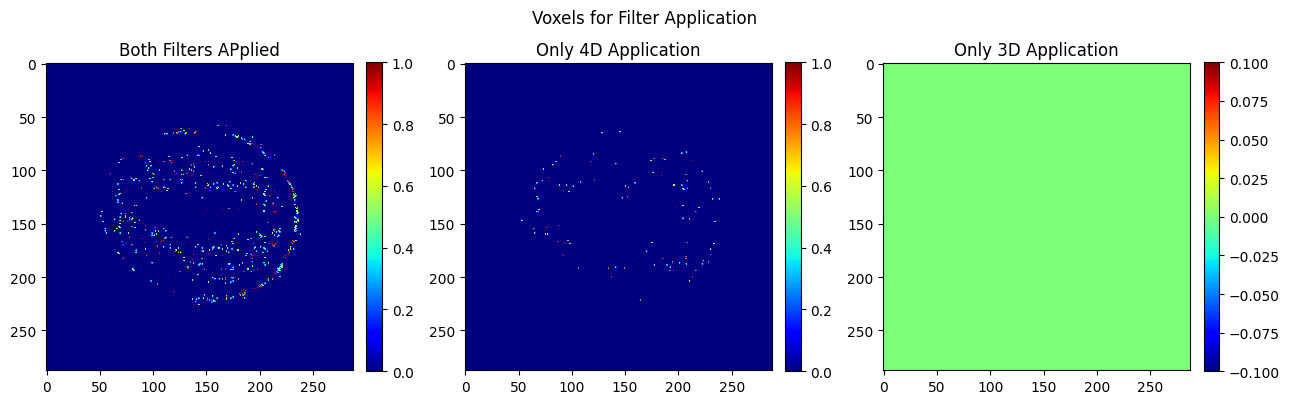

In [42]:
filter_applied_4D = np.sum(np.abs((I_filtered_4D-I_mask4))[:,:,slice_roi,:],axis = 2)>0
filter_applied_3D = np.sum(np.abs(I_filtered-I_mask3),axis = 2)>0

fig, ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
fig.suptitle('Voxels for Filter Application')
imc1 = ax[0].imshow(filter_applied_4D, cmap = 'jet')
ax[0].set_title('4D Application')

imc2 = ax[1].imshow(filter_applied_3D, cmap = 'jet')
ax[1].set_title('3D Application')

fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)
plt.show()

overlap = filter_applied_4D*filter_applied_3D
only_4D = filter_applied_4D ^ overlap
only_3D = filter_applied_3D ^ overlap

fig, ax = plt.subplots(1,3,figsize=(13,4),tight_layout=True)
fig.suptitle('Voxels for Filter Application')
imc1 = ax[0].imshow(overlap, cmap = 'jet')
ax[0].set_title('Both Filters APplied')

imc2 = ax[1].imshow(only_4D, cmap = 'jet')
ax[1].set_title('Only 4D Application')

imc3 = ax[2].imshow(only_3D, cmap = 'jet')
ax[2].set_title('Only 3D Application')

fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04)
plt.show()

# NLLS Results

In [25]:
I4_norm = normalize_brain(I_filtered_4D[:,:,slice_roi,:])
parameter_maps_NLLS_4D = create_NLLS_map(I4_norm)

I3_norm = normalize_brain(I_filtered)
parameter_maps_NLLS_3D = create_NLLS_map(I3_norm)

100%|██████████| 288/288 [5:50:39<00:00, 73.05s/it]   


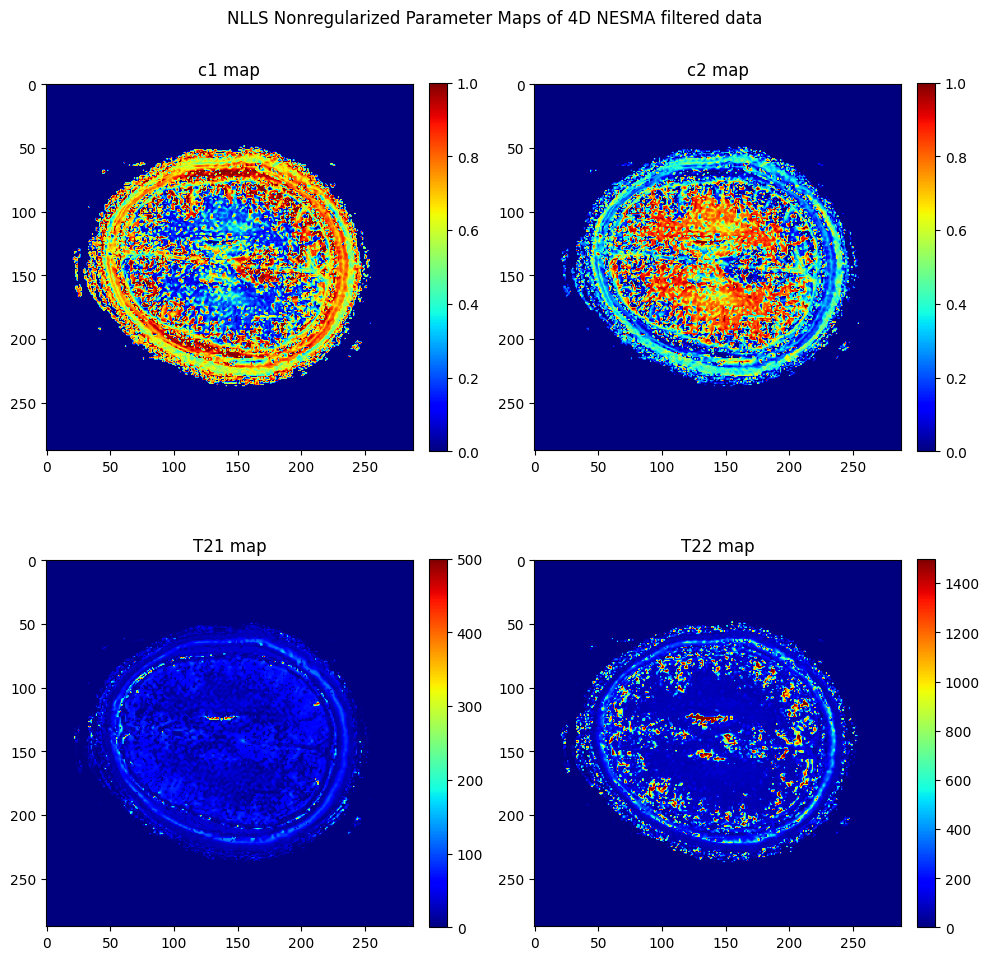

In [26]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('NLLS Nonregularized Parameter Maps of 4D NESMA filtered data')
imc1 = ax[0,0].imshow(parameter_maps_NLLS_4D[:,:,0], cmap = 'jet', vmin=0, vmax=1)
ax[0,0].set_title('c1 map')

imc2 = ax[0,1].imshow(parameter_maps_NLLS_4D[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')

imT21 = ax[1,0].imshow(parameter_maps_NLLS_4D[:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('T21 map')

imT22 = ax[1,1].imshow(parameter_maps_NLLS_4D[:,:,3], cmap = 'jet')
ax[1,1].set_title('T22 map')

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

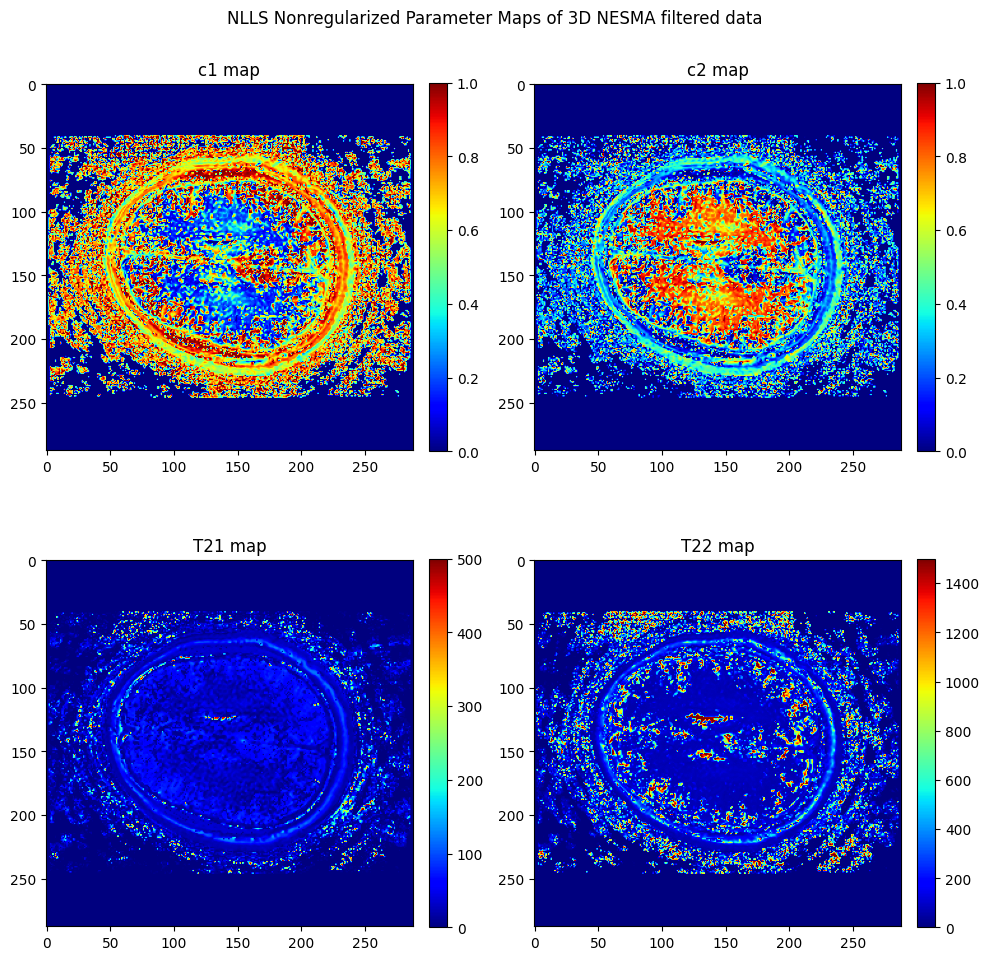

In [27]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('NLLS Nonregularized Parameter Maps of 3D NESMA filtered data')
imc1 = ax[0,0].imshow(parameter_maps_NLLS_3D[:,:,0], cmap = 'jet', vmin=0, vmax=1)
ax[0,0].set_title('c1 map')

imc2 = ax[0,1].imshow(parameter_maps_NLLS_3D[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')

imT21 = ax[1,0].imshow(parameter_maps_NLLS_3D[:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('T21 map')

imT22 = ax[1,1].imshow(parameter_maps_NLLS_3D[:,:,3], cmap = 'jet')
ax[1,1].set_title('T22 map')

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

# Figures for NESMA product

In [ ]:
#Normalize the NESMA filtered data and account for Rician noise
I_norm_NESMA = np.zeros(I_slice.shape)
for i_hori in trange(I_slice.shape[0]):
    for i_vert in range(I_slice.shape[1]):
        #for i_slice in range(n_slices):
        data = I_filtered[i_hori,i_vert,:]
            #Account for the Rician noise
        signal_end = data[(I_slice.shape[-1]-10):]
        rician_correction = np.mean(signal_end)
        data_shifted = data-rician_correction
            #Normalize the data
        data_shifted = np.array(data_shifted/data_shifted[0])

        I_norm_NESMA[i_hori,i_vert,:] = data_shifted

  0%|          | 0/288 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_4704\3990698638.py:12: RuntimeWarning: invalid value encountered in divide
  data_shifted = np.array(data_shifted/data_shifted[0])
 14%|█▎        | 39/288 [00:00<00:02, 88.68it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_4704\3990698638.py:12: RuntimeWarning: divide by zero encountered in divide
  data_shifted = np.array(data_shifted/data_shifted[0])
100%|██████████| 288/288 [00:02<00:00, 101.25it/s]


  0%|          | 0/288 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_4704\4161238884.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  brain_SNR_temp = data[0]/brain_noise_sd
100%|██████████| 288/288 [00:02<00:00, 142.69it/s]


ValueError: supplied range of [0.23408229439226114, inf] is not finite

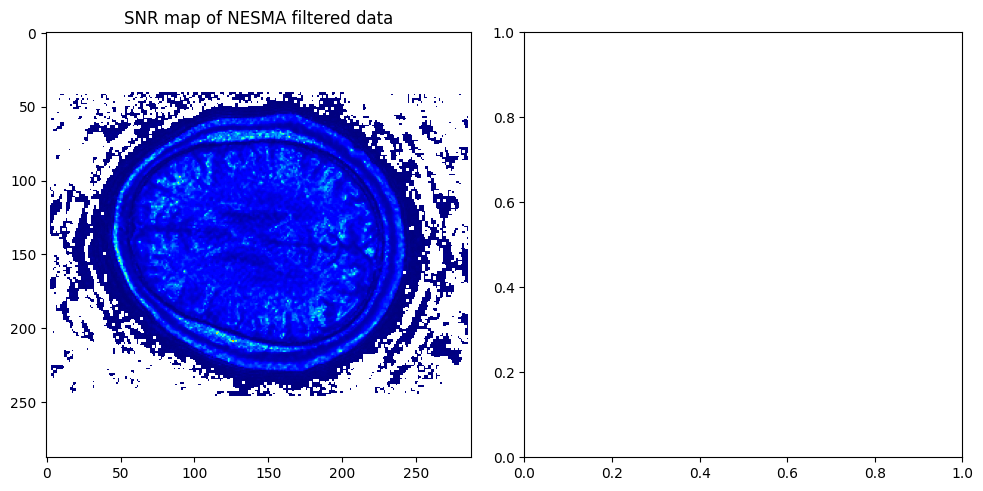

In [ ]:
brain_SNR_map_NESMA = np.zeros((I_slice.shape[0], I_slice.shape[1]))
for i_hori in trange(I_slice.shape[0]):
    for i_vert in range(I_slice.shape[1]):
        data = I_filtered[i_hori,i_vert,:]
        if data[0]>0:
            signal_end = data[(I_slice.shape[-1]-10):] #Accounting for noise in the data - Rician noise
            
            brain_noise_sd = np.std(signal_end)
            brain_SNR_temp = data[0]/brain_noise_sd
            brain_SNR_map_NESMA[i_hori, i_vert] = brain_SNR_temp
        else:
            brain_SNR_map_NESMA[i_hori, i_vert] = None
            
fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
imc1 = ax[0].imshow(brain_SNR_map_NESMA, cmap = 'jet')
ax[0].set_title('SNR map of NESMA filtered data')

n, bins, patches = ax[1].hist(np.reshape(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0],-1), bins=20)
bincenters_NESMA = 0.5*(bins[1:]+bins[:-1])
#print(bincenters_NESMA)
print('SNR mean:',np.mean(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0]))
ax[1].set_title('Histogram of SNR of NESMA filtered data')

fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)

plt.show()